In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import gwpy.timeseries
from scipy.io import loadmat

import sys
sys.path.insert(0,'../src')
from util import *
from cross_correlation import *
from postprocessing import *
from pe import *
from constants import *

In [2]:
matplotlib.rcParams.update({'font.size':15})

# Analysis parameters

In [3]:
# 192s
offset = 88 # 88 seconds so start time aligns with stochastic.m run here: https://git.ligo.org/stochastic-public/stochastic/-/blob/O2StochIso/example_output_for_comparison.txt
tstart = 1184098680
dur = 2672 # duration of job
tend=tstart+dur

deltaF=1./32
segmentDuration=192

In [4]:
# 64s
#offset = 24 # 88 seconds so start time aligns with stochastic.m run here: https://git.ligo.org/stochastic-public/stochastic/-/blob/O2StochIso/example_output_for_comparison.txt
#tstart = 1184098680 
#dur = 2672 # duration of job
#tend=tstart+dur

#deltaF=1./64
#segmentDuration=64

# Get data

In [5]:
try:
    data_H1=gwpy.timeseries.TimeSeries.read('data/data_H1.gwf','Strain')
    data_L1=gwpy.timeseries.TimeSeries.read('data/data_L1.gwf','Strain')
except:
    data_H1=gwpy.timeseries.TimeSeries.fetch_open_data('H1',tstart,tend)
    data_L1=gwpy.timeseries.TimeSeries.fetch_open_data('L1',tstart,tend)
    data_H1.write('data/data_H1.gwf')
    data_L1.write('data/data_L1.gwf')

In [6]:
t,h = data_H1.times.value,data_H1.value
fs = int(1/data_H1.dt.value)
nan_filter=np.isnan(h)
h[nan_filter]=0
cut=t>tstart+offset
t=t[cut]
h=h[cut]
d1=TimeSeries(t,h)

In [7]:
t,h = data_L1.times.value,data_L1.value
fs = int(1/data_L1.dt.value)
nan_filter=np.isnan(h)
h[nan_filter]=0
cut=t>tstart+offset
t=t[cut]
h=h[cut]
d2=TimeSeries(t,h)

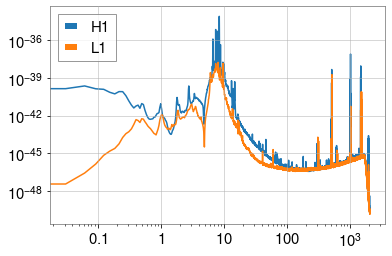

In [8]:
# plot PSDs as a sanity check

nperseg=int(d1.Fs/deltaF)
freqs,P1_test = welch_psd(d1.data,nperseg=nperseg,window='Hann',fs=d1.Fs)

nperseg=int(d2.Fs/deltaF)
freqs,P2_test = welch_psd(d2.data,nperseg=nperseg,window='Hann',fs=d2.Fs)

plt.loglog(freqs,P1_test,label='H1')
plt.loglog(freqs,P2_test,label='L1')
plt.legend()

# Cross correlation analysis

In [9]:
Ys,sigs,Y_ft,var_ft,segmentStartTimes,freqs=cross_correlation(d1,
                                                       d2,
                                                       segmentDuration,
                                                       deltaF,
                                                       verbose=False,
                                                       doOverlap=True,
                                                       alpha=0,
                                                       fref=25,
                                                       orf_file='../src/orfs/ORF_HL.dat',
                                                             fmin=20,fmax=1726)


../src/cross_correlation.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  Ys[II],sigs[II] = calc_Y_sigma_from_Yf_varf(Y_f.data,var_f.data)
../src/cross_correlation.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_ft[:,II],var_ft[:,II] = Y_f.data, var_f.data


In [10]:
Y_t = np.zeros(len(segmentStartTimes)-1)
var_t = np.zeros(len(segmentStartTimes)-1)

for ii in range(len(Y_t)):
    var_t[ii] = 1/np.sum(var_ft[:,ii]**(-1))
    Y_t[ii] = np.sum(Y_ft[:,ii] * var_t[ii]/var_ft[:,ii])
    
    print('segment = %u, start sec = %u, CC stat = %e, theor sigma = %e, SNR=%f'%(ii+3,
                                                                       segmentStartTimes[ii],
                                                                       np.real(Y_t[ii]) * segmentDuration,
                                                                       np.sqrt(var_t[ii]) * segmentDuration,
                                                                       np.real(Y_t[ii])/np.sqrt(var_t[ii])))


segment = 3, start sec = 1184098960, CC stat = 5.017664e-04, theor sigma = 7.127023e-04, SNR=0.704034
segment = 4, start sec = 1184099056, CC stat = 7.584695e-04, theor sigma = 6.869701e-04, SNR=1.104079
segment = 5, start sec = 1184099152, CC stat = -1.462822e-03, theor sigma = 6.910389e-04, SNR=-2.116845
segment = 6, start sec = 1184099248, CC stat = -6.414395e-04, theor sigma = 7.125490e-04, SNR=-0.900204
segment = 7, start sec = 1184099344, CC stat = 7.379800e-04, theor sigma = 6.956847e-04, SNR=1.060797
segment = 8, start sec = 1184099440, CC stat = -9.496543e-04, theor sigma = 6.933487e-04, SNR=-1.369663
segment = 9, start sec = 1184099536, CC stat = 5.583676e-04, theor sigma = 7.078317e-04, SNR=0.788842
segment = 10, start sec = 1184099632, CC stat = -1.448800e-04, theor sigma = 7.234573e-04, SNR=-0.200261
segment = 11, start sec = 1184099728, CC stat = -5.184129e-04, theor sigma = 8.163242e-04, SNR=-0.635058
segment = 12, start sec = 1184099824, CC stat = -3.362117e-04, theor s

# Post processing and comparison with matlab

In [11]:
h0=0.679 # hubble correction

In [12]:
Y_f,var_f=postprocessing_spectra(Y_ft,var_ft,dur,segmentDuration,
                                 deltaF,1/d1.Fs)

Y_f = Y_f / h0**2
var_f = var_f / h0**4
sigma_f = np.sqrt(var_f)

In [13]:
spectrum_file='matlab_for_O2_comparison/command/narrowband_stats.mat'
tmp=loadmat(spectrum_file)

In [14]:
freqs_matlab=np.transpose(tmp['freq'].flatten())
Y_f_matlab=np.real(tmp['ptEst_ff'].flatten())
sigma_f_matlab=tmp['sigma_ff'].flatten()

In [15]:
print('Comparing sigmas')
sm_sig=np.sqrt(1/np.sum(sigma_f_matlab**(-2)))
sl_sig=np.sqrt(1/np.sum(sigma_f**(-2)))
err_sig = np.abs((sm_sig-sl_sig)/sl_sig)
print('\tstochastic.m: %e'%sm_sig)
print('\tstochastic_lite: %e'%sl_sig)
print('\t%% diff: %f%%'%(100*err_sig))

sm_y=np.sum(Y_f_matlab*sigma_f_matlab**(-2)) / np.sum(sigma_f_matlab**(-2))
sl_y=np.sum(Y_f*sigma_f**(-2)) / np.sum(sigma_f**(-2))
err_y = np.abs((sm_y-sl_y)/sl_y)
print('Comparing point estimates')
print('\tstochastic.m: %e'%(sm_y))
print('\tstochastic_lite: %e'%(sl_y))
print('\t%% diff: %f%%'%(100*err_y))

Comparing sigmas
	stochastic.m: 1.939605e-06
	stochastic_lite: 1.942621e-06
	% diff: 0.155230%
Comparing point estimates
	stochastic.m: 5.954429e-07
	stochastic_lite: 5.984385e-07
	% diff: 0.500556%


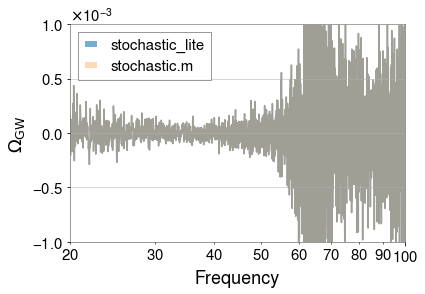

In [16]:
plt.semilogx(freqs,Y_f,alpha=0.6,label='stochastic_lite')
plt.semilogx(freqs_matlab,Y_f_matlab,alpha=0.3,label='stochastic.m')
plt.xlim(20,100)
plt.ylim(-1e-3,1e-3)
plt.xlabel('Frequency')
plt.ylabel(r'$\Omega_{\rm GW}$')
plt.legend()

Text(0.5, 1.0, 'Relative difference in $\\hat{C}(f)$')

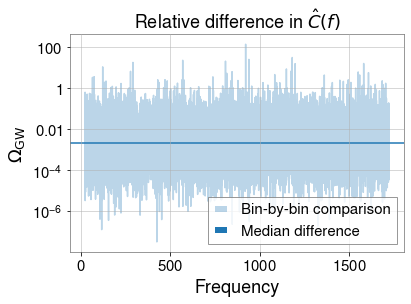

In [17]:
plt.semilogy(freqs_matlab,np.abs(Y_f-Y_f_matlab)/np.abs(Y_f),alpha=0.3,label='Bin-by-bin comparison')
plt.axhline(np.median(np.abs(Y_f-Y_f_matlab)/np.abs(Y_f)),label='Median difference')

plt.xlabel('Frequency')
plt.ylabel(r'$\Omega_{\rm GW}$')
plt.legend()
plt.title('Relative difference in $\hat{C}(f)$')

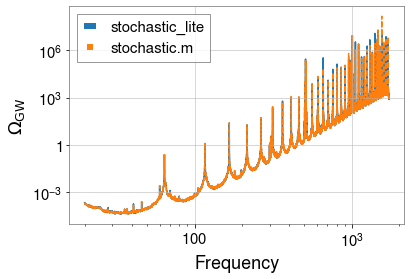

In [18]:
plt.loglog(freqs,sigma_f,label='stochastic_lite')
plt.loglog(freqs_matlab,sigma_f_matlab,linestyle='--',label='stochastic.m')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel(r'$\Omega_{\rm GW}$')
plt.legend()

Text(0.5, 1.0, 'Relative difference in $\\sigma(f)$')

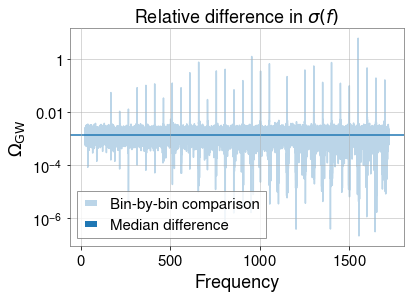

In [19]:
plt.semilogy(freqs_matlab,np.abs(sigma_f-sigma_f_matlab)/np.abs(sigma_f),alpha=0.3,label='Bin-by-bin comparison')
plt.axhline(np.median(np.abs(sigma_f-sigma_f_matlab)/np.abs(sigma_f)),label='Median difference')

plt.xlabel('Frequency')
plt.ylabel(r'$\Omega_{\rm GW}$')
plt.legend()
plt.title('Relative difference in $\sigma(f)$')